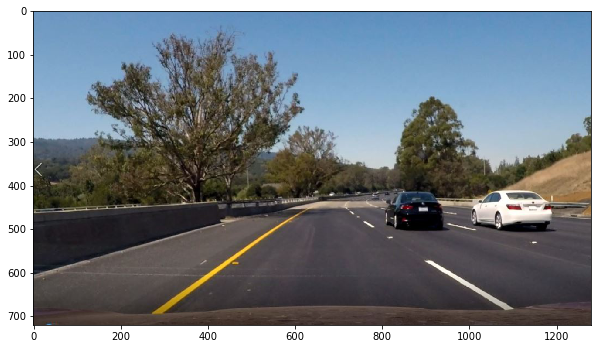

In [1]:
import threading
import os

import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip, concatenate_videoclips, ImageSequenceClip
from IPython.display import HTML
from tqdm import tqdm_notebook

from mylib import *

exec(open("./vehicleScan.py").read())
#from vehicleScan import *


n = 7
hot_frames = []
image = cv2.imread('./test_images/test'+str(n)+'.jpg')
image = cv2.resize(image, (1280, 720))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.show()


Frame dimensions (w x h): (1280, 720)
Created required Windows to scan.


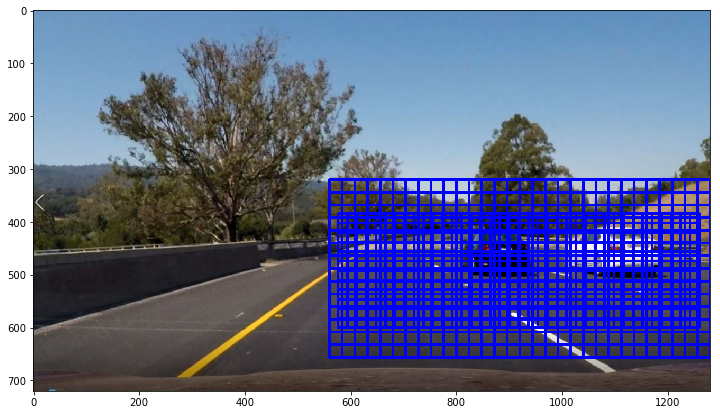

In [2]:
# global variables for output video
fps = None

# global variables for processing video
all_frames = []    # all the frames in original video
vid = "project"
# get fps and frame from the input video
output_vid = "./output_videos/"+vid+"_video.mp4"
in_clip = VideoFileClip(vid+"_video.mp4")
fps = in_clip.fps

# Read all the frames into memory along with frame numbers
f_frame = None
for frame in in_clip.iter_frames():
    f_frame = frame
    break


# Processing variables
proc_data={
    "orient" : 11,
    "pix_per_cell" : 8,
    "cell_per_block" : 2,
    "spatial" : 16,
    "hbins" : 32,
    "overlap" : 0.75,
    "inc_spatial" : True,
    "inc_hist" : True,
    # training image size
    "trained_win_size" : 64,
    # list of windows for each window size
    "windows" : {96: Window(), 72: Window()},
    "frame_height" : f_frame.shape[0],
    "frame_width" : f_frame.shape[1]
}

# vertical scanning area
y_fullrange_img = [((proc_data["frame_height"]//2)//64)*64, proc_data["frame_height"]-48]
# image scanning area height
y_len = y_fullrange_img[1] - y_fullrange_img[0]
# range_offsets along x-axis for each window
x_offset = {96:0, 72:16}#proc_data["frame_width"]//8}
# range_offsets along y-axis for each window
y_offset = {96:0, 72:64}

##### Create all the Windows
for win_size in proc_data["windows"]:
    proc_data["windows"][win_size].windows
    # scan range for y-axis
    y_range_img = [y_fullrange_img[0] + y_offset[win_size], y_fullrange_img[1] - y_offset[win_size]]
    # get x range for search
    x_range_img = [x_offset[win_size]+(7*proc_data["frame_width"]//16),
                   proc_data["frame_width"] - x_offset[win_size]]
    proc_data["windows"][win_size].windows = get_windows(image, x_start_stop=x_range_img, y_start_stop=y_range_img,
                                        xy_window=(win_size, win_size),
                                        xy_overlap=(proc_data["overlap"], proc_data["overlap"]), draw=True)
    proc_data["windows"][win_size].x_range_img = x_range_img
    proc_data["windows"][win_size].y_range_img = y_range_img
print("Frame dimensions (w x h):", (f_frame.shape[:2])[::-1])
print("Created required Windows to scan.")
fig = plt.figure(figsize=(20, 7))
plt.imshow(image)
plt.show()

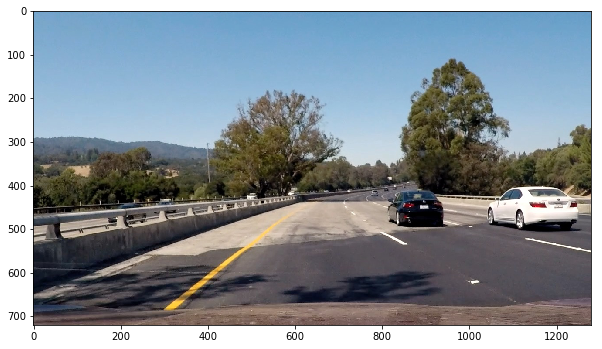

Time taken to predict: 3.58 seconds


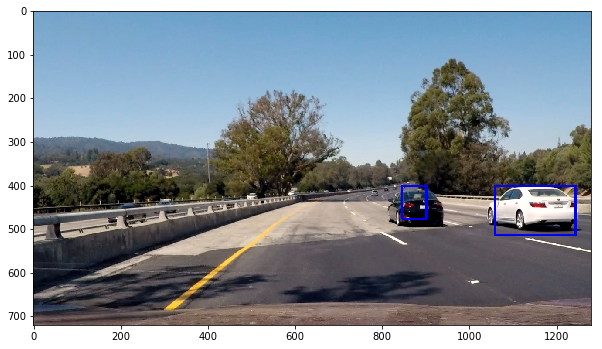

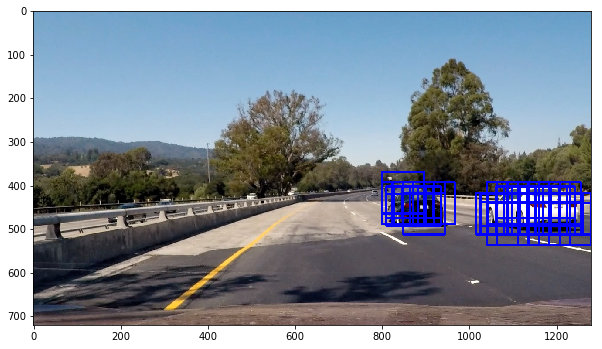

In [3]:
def get_processed_image(img, label_only):
    global svc, X_scaler, proc_data
    # float64 type heat map
    heat_map, dimg = find_cars(img, svc, X_scaler, proc_data["orient"],
                        proc_data["pix_per_cell"], proc_data["cell_per_block"], proc_data["inc_spatial"], 
                        proc_data["spatial"], proc_data["inc_hist"], proc_data["hbins"], proc_data["overlap"],
                        proc_data["trained_win_size"], proc_data["windows"], draw_detections=True)
    
    # normalize the heatmap to be in range 0-255 and change data type to be uint8
    nheat_map = (heat_map/np.max(heat_map))*254
    nheat_map.astype(np.uint8)
    # remove unwanted heat by thresholding and smoothen the output using gaussian blur
    nheat_map = cool_heat(nheat_map, 80)
    nheat_map = cv2.GaussianBlur(nheat_map, (5,5), 0)
    # generate labels for hot boxes and draw them onto output image
    op = draw_labeled_bboxes(img, label(nheat_map))
    # superimpose heatmap on one corner fo output video
    if not label_only:
        mini_hm = cv2.resize(nheat_map, (360, 240))
        mini_hm = np.dstack((mini_hm, np.zeros_like(mini_hm), np.zeros_like(mini_hm)))
        op[0:240, op.shape[1]-360:op.shape[1]] = mini_hm
    return op, dimg

svc = joblib.load('svm_model.pkl')
X_scaler = joblib.load('svm_scaler.pkl')
hot_frames = []
frames_sum = None
n = 4
image = cv2.imread('./test_images/test'+str(n)+'.jpg')
image = cv2.resize(image, (1280, 720))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.show()

t0 = time.time()
op, mdt_img = get_processed_image(image, True)
t1 = time.time()
print("Time taken to predict:", round((t1-t0), 2),"seconds")
plt.figure(figsize=(10, 6))
plt.imshow(op)
plt.show()
plt.figure(figsize=(10, 6))
plt.imshow(mdt_img)
plt.show()